In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [269]:
# We define VM Class and Task Class
class VM:
    def __init__(self, id, cpu, ram):
        self.id = id
        self.cpu = cpu
        self.ram = ram
        self.cost = cpu / 10
        self.available_cpu = cpu
        self.available_ram = ram

class Task:
    def __init__(self, id, instructions, memory, deadline):
        self.id = id
        self.instructions = instructions
        self.memory = memory
        self.deadline = deadline

In [270]:
# round robin algorithm
def round_robin_allocate(vms, tasks):
    allocations = []
    vm_index = 0
    num_vms = len(vms)
    
    for task in tasks:
        vm_id = vm_index % num_vms
        allocations.append(vm_id)
        vm_index += 1
    
    return allocations

def rr_optimize(vms, tasks):
    allocations = round_robin_allocate(vms, tasks)
    return run_simulation(allocations, vms, tasks)

In [271]:
# shortest job first algorithm
def sjf_allocate(vms, tasks):
    sorted_tasks = sorted(enumerate(tasks), key=lambda x: x[1].instructions)
    allocations = [0] * len(tasks)
    vm_loads = [0] * len(vms)
    
    for task_index, task in sorted_tasks:
        vm_id = min(range(len(vms)), key=lambda i: vm_loads[i])
        allocations[task_index] = vm_id
        vm_loads[vm_id] += task.instructions
    
    return allocations

def sjf_optimize(vms, tasks):
    allocations = sjf_allocate(vms, tasks)
    return run_simulation(allocations, vms, tasks)

In [272]:
def calculate_overutilization_penalty(vm_utilization, vms):
    penalty = 0
    for vm in vms:
        cpu_overuse = max(0, vm_utilization[vm.id]['cpu'] - vm.cpu)
        ram_overuse = max(0, vm_utilization[vm.id]['ram'] - vm.ram)
        penalty += (cpu_overuse / vm.cpu + ram_overuse / vm.ram) * 1000
    return penalty

In [273]:
def flexible_allocate_tasks(vm_preferences, vms, tasks):
    allocations = []
    vm_utilization = {vm.id: {'cpu': 0, 'ram': 0} for vm in vms}
    
    for task_id, preferred_vm_id in enumerate(vm_preferences):
        task = tasks[task_id]
        allocated_cpu = 0
        allocated_ram = 0
        task_allocations = []

        # Try to allocate to the preferred VM first
        preferred_vm = vms[preferred_vm_id]
        alloc_cpu = min(task.instructions - allocated_cpu, preferred_vm.cpu - vm_utilization[preferred_vm.id]['cpu'])
        alloc_ram = min(task.memory - allocated_ram, preferred_vm.ram - vm_utilization[preferred_vm.id]['ram'])
        
        if alloc_cpu > 0 or alloc_ram > 0:
            task_allocations.append((preferred_vm.id, alloc_cpu, alloc_ram))
            vm_utilization[preferred_vm.id]['cpu'] += alloc_cpu
            vm_utilization[preferred_vm.id]['ram'] += alloc_ram
            allocated_cpu += alloc_cpu
            allocated_ram += alloc_ram

        # If task is not fully allocated, try other VMs
        for vm in vms:
            if allocated_cpu >= task.instructions and allocated_ram >= task.memory:
                break
            if vm.id == preferred_vm.id:
                continue
            
            alloc_cpu = min(task.instructions - allocated_cpu, vm.cpu - vm_utilization[vm.id]['cpu'])
            alloc_ram = min(task.memory - allocated_ram, vm.ram - vm_utilization[vm.id]['ram'])
            
            if alloc_cpu > 0 or alloc_ram > 0:
                task_allocations.append((vm.id, alloc_cpu, alloc_ram))
                vm_utilization[vm.id]['cpu'] += alloc_cpu
                vm_utilization[vm.id]['ram'] += alloc_ram
                allocated_cpu += alloc_cpu
                allocated_ram += alloc_ram

        allocations.append(task_allocations)

    return allocations, vm_utilization

In [274]:
def run_simulation(vm_preferences, vms, tasks):
    allocations, vm_utilization = flexible_allocate_tasks(vm_preferences, vms, tasks)
    
    total_cost = 0
    total_energy = 0
    max_execution_time = 0
    
    for task_id, task_allocations in enumerate(allocations):
        task = tasks[task_id]
        task_execution_time = 0
        for vm_id, alloc_cpu, alloc_ram in task_allocations:
            vm = next(vm for vm in vms if vm.id == vm_id)
            execution_time = alloc_cpu / vm.cpu * 1000  # ms
            task_execution_time += execution_time
            
            # Calculate cost based on resource usage and time
            cost = vm.cost * (execution_time / 1000) * (alloc_cpu / vm.cpu)
            total_cost += cost
            
            # Calculate energy based on CPU utilization and time
            energy = (alloc_cpu / vm.cpu) * (execution_time / 1000)
            total_energy += energy
        
        max_execution_time = max(max_execution_time, task_execution_time)
    
    overutilization_penalty = calculate_overutilization_penalty(vm_utilization, vms)
    
    return max_execution_time, total_cost, total_energy, overutilization_penalty

def evaluate(individual, vms, tasks):
    return run_simulation(individual, vms, tasks)

In [275]:
def check_fitness(individual):
    makespan, cost, energy, overutilization_penalty = run_simulation(individual, vms, tasks)
    
    # Normalize and combine objectives
    normalized_makespan = makespan / 1000
    normalized_cost = cost / 1000
    normalized_energy = energy / 5

    weighted_sum = (normalized_makespan * 0.3 + 
                    normalized_cost * 0.3 + 
                    normalized_energy * 0.2 + 
                    overutilization_penalty * 0.2)
    
    return weighted_sum, makespan, cost, energy, overutilization_penalty

In [276]:
#FWA
def fwa_optimize(vms,tasks):
    def generate_sparks(firework, n, amplitude, num_vms):
        return [
            [max(0, min(num_vms - 1, x + int(random.uniform(-amplitude, amplitude))))
             for x in firework]
            for _ in range(n)
        ]
    def fireworks_algorithm(vms, tasks, n_fireworks=5, n_sparks=30, n_iterations=40):
        num_vms = len(vms)
        num_tasks = len(tasks)

        # Initialize fireworks
        fireworks = [random.choices(range(num_vms), k=num_tasks) for _ in range(n_fireworks)]
        best_solution = None
        best_fitness = float('inf')

        for _ in range(n_iterations):
            all_solutions = fireworks.copy()

            # Generate sparks
            for firework in fireworks:
                fitness = check_fitness(firework)[0]
                if fitness < best_fitness:
                    best_fitness = fitness
                    best_solution = firework

                # Calculate amplitude, ensuring it's within a reasonable range
                amplitude = max(1, int(50 * best_fitness / fitness))

                all_solutions.extend(generate_sparks(firework, n_sparks, amplitude, num_vms))

            # Evaluate and select best solutions
            all_solutions.sort(key=lambda x: check_fitness(x)[0])
            fireworks = all_solutions[:n_fireworks]

        return best_solution, best_fitness

    best_solution, best_fitness = fireworks_algorithm(vms, tasks)
    return evaluate(best_solution, vms, tasks)

In [277]:
#SQSA
def sqsa_optimize(vms, tasks, n_squirrels=30, n_iterations=40):
    squirrels = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_squirrels)]
    fitness = [check_fitness(s)[0] for s in squirrels]

    best_idx = fitness.index(min(fitness))
    
    for _ in range(n_iterations):
        for i in range(n_squirrels):
            if i != best_idx:
                for j in range(len(tasks)):
                    if random.random() < 0.5:
                        squirrels[i][j] = squirrels[best_idx][j]
                    else:
                        squirrels[i][j] = random.randint(0, len(vms)-1)
        
        fitness = [check_fitness(s)[0] for s in squirrels]
        new_best_idx = fitness.index(min(fitness))
        if fitness[new_best_idx] < fitness[best_idx]:
            best_idx = new_best_idx

    return evaluate(squirrels[best_idx], vms, tasks)

In [278]:
# BAT
def bat_optimize(vms, tasks, n_bats=30, n_iterations=40):
    bats = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_bats)]
    velocities = [[0] * len(tasks) for _ in range(n_bats)]
    fitness = [check_fitness(b)[0] for b in bats]
    best_bat = bats[fitness.index(min(fitness))]
    
    for _ in range(n_iterations):
        for i in range(n_bats):
            freq = random.random()
            for j in range(len(tasks)):
                velocities[i][j] += (bats[i][j] - best_bat[j]) * freq
                bats[i][j] = max(0, min(len(vms)-1, int(bats[i][j] + velocities[i][j])))
            
            if random.random() > 0.5:
                bats[i] = [max(0, min(len(vms)-1, best_bat[j] + int(random.gauss(0, 1))))
                           for j in range(len(tasks))]
        
        fitness = [check_fitness(b)[0] for b in bats]
        best_idx = fitness.index(min(fitness))
        if fitness[best_idx] < check_fitness(best_bat)[0]:
            best_bat = bats[best_idx]
    return evaluate(best_bat, vms, tasks)

In [279]:
# PSO
def pso_optimize(vms, tasks, n_particles=30, n_iterations=40):
    particles = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_particles)]
    velocities = [[0] * len(tasks) for _ in range(n_particles)]
    personal_best = particles.copy()
    fitness = [check_fitness(p)[0] for p in particles]
    global_best = particles[fitness.index(min(fitness))]
    best_fitness = min(fitness)
    
    for _ in range(n_iterations):
        for i in range(n_particles):
            # Update velocity and position
            new_particle = []
            for j in range(len(tasks)):
                r1, r2 = random.random(), random.random()
                velocities[i][j] = (0.5 * velocities[i][j] + 
                                    1 * r1 * (personal_best[i][j] - particles[i][j]) +
                                    2 * r2 * (global_best[j] - particles[i][j]))
                new_position = particles[i][j] + velocities[i][j]
                new_particle.append(max(0, min(len(vms)-1, int(new_position))))
            
            # Evaluate new position
            current_fitness = check_fitness(new_particle)[0]
            
            # Update personal best
            if current_fitness < fitness[i]:
                personal_best[i] = new_particle
                fitness[i] = current_fitness
                
                # Update global best
                if current_fitness < best_fitness:
                    best_fitness = current_fitness
                    global_best = new_particle
            
            # Update particle position
            particles[i] = new_particle

    return evaluate(global_best, vms, tasks)

In [280]:
# BMO
def bmo_optimize(vms, tasks, n_barnacles=30, n_iterations=40):
    barnacles = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_barnacles)]
    fitness = [check_fitness(b)[0] for b in barnacles]
    best_barnacle = barnacles[fitness.index(min(fitness))]
    
    for _ in range(n_iterations):
        for i in range(n_barnacles):
            if random.random() < 0.5:  # Pseudo-fertilization
                partner = random.choice(barnacles)
                barnacles[i] = [b if random.random() < 0.5 else p 
                                for b, p in zip(barnacles[i], partner)]
            else:  # Larval development
                barnacles[i] = [max(0, min(len(vms)-1, x + int(random.gauss(0, 1))))
                                for x in barnacles[i]]
        
        fitness = [check_fitness(b)[0] for b in barnacles]
        new_best = barnacles[fitness.index(min(fitness))]
        if check_fitness(new_best)[0] < check_fitness(best_barnacle)[0]:
            best_barnacle = new_best

    return evaluate(best_barnacle, vms, tasks)

In [281]:
#SSA
def ssa_optimize(vms, tasks, n_sparrows=30, n_iterations=40):
    sparrows = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_sparrows)]
    fitness = [check_fitness(s)[0] for s in sparrows]
    best_sparrow = sparrows[fitness.index(min(fitness))]
    
    for _ in range(n_iterations):
        for i in range(n_sparrows):
            if i < n_sparrows // 5:  # Discoverer
                sparrows[i] = [max(0, min(len(vms)-1, x + int(random.gauss(0, 1))))
                               for x in sparrows[i]]
            elif i < n_sparrows // 2:  # Joiner
                sparrows[i] = [best_sparrow[j] if random.random() < 0.5 else sparrows[i][j]
                               for j in range(len(tasks))]
            else:  # Scrounger
                sparrows[i] = [random.randint(0, len(vms)-1) if random.random() < 0.1 else sparrows[i][j]
                               for j in range(len(tasks))]
        
        fitness = [check_fitness(s)[0] for s in sparrows]
        new_best = sparrows[fitness.index(min(fitness))]
        if check_fitness(new_best)[0] < check_fitness(best_sparrow)[0]:
            best_sparrow = new_best

    return evaluate(best_sparrow, vms, tasks)

# Results->

Fix no of tasks to 100 and no of VMs range from 10 to 40

In [286]:
makespan_results=pd.DataFrame(columns=["No of VMs","RR","SJF","FWA","SQSA","BAT","PSO","BMO","SSA"])
cost_results=pd.DataFrame(columns=["No of VMs","RR","SJF","FWA","SQSA","BAT","PSO","BMO","SSA"])
energy_results=pd.DataFrame(columns=["No of VMs","RR","SJF","FWA","SQSA","BAT","PSO","BMO","SSA"])

In [287]:
num_vms = 40
num_tasks = 100

In [288]:
rr_mean_makespan,rr_mean_energy,rr_mean_cost=0,0,0
sjf_mean_makespan,sjf_mean_energy,sjf_mean_cost=0,0,0
fwa_mean_makespan,fwa_mean_energy,fwa_mean_cost=0,0,0
sqsa_mean_makespan,sqsa_mean_energy,sqsa_mean_cost=0,0,0
bat_mean_makespan,bat_mean_energy,bat_mean_cost=0,0,0
pso_mean_makespan,pso_mean_energy,pso_mean_cost=0,0,0
bmo_mean_makespan,bmo_mean_energy,bmo_mean_cost=0,0,0
ssa_mean_makespan,ssa_mean_energy,ssa_mean_cost=0,0,0

In [290]:
n=10
for _ in range(n):
    vms = [VM(i, random.randint(1000, 3000), random.randint(1000, 2000)) for i in range(num_vms)]
    tasks = [Task(i, random.randint(100, 500), random.randint(100, 500), random.randint(50, 500)) for i in range(num_tasks)]
    
    # RR
    rr_makespan, rr_cost, rr_energy= rr_optimize(vms, tasks)[:3]
    rr_mean_makespan+=rr_makespan
    rr_mean_cost+=rr_cost
    rr_mean_energy+=rr_energy
    
    # SJF
    sjf_makespan, sjf_cost, sjf_energy= sjf_optimize(vms, tasks)[:3]
    sjf_mean_makespan+=sjf_makespan
    sjf_mean_cost+=sjf_cost
    sjf_mean_energy+=sjf_energy
    
    #FWA
    fwa_makespan, fwa_cost, fwa_energy= fwa_optimize(vms, tasks)[:3]
    fwa_mean_makespan+=fwa_makespan
    fwa_mean_cost+=fwa_cost
    fwa_mean_energy+=fwa_energy
    
    #SQSA
    sqsa_makespan, sqsa_cost, sqsa_energy= sqsa_optimize(vms, tasks)[:3]
    sqsa_mean_makespan+=sqsa_makespan
    sqsa_mean_cost+=sqsa_cost
    sqsa_mean_energy+=sqsa_energy

    #BAT
    bat_makespan, bat_cost, bat_energy= bat_optimize(vms, tasks)[:3]
    bat_mean_makespan+=bat_makespan
    bat_mean_cost+=bat_cost
    bat_mean_energy+=bat_energy
    
    #PSO
    pso_makespan, pso_cost, pso_energy= pso_optimize(vms, tasks)[:3]
    pso_mean_makespan+=pso_makespan
    pso_mean_cost+=pso_cost
    pso_mean_energy+=pso_energy

    #BMO
    bmo_makespan, bmo_cost, bmo_energy= bmo_optimize(vms, tasks)[:3]
    bmo_mean_makespan+=bmo_makespan
    bmo_mean_cost+=bmo_cost
    bmo_mean_energy+=bmo_energy
    
    #SSA
    ssa_makespan, ssa_cost, ssa_energy= ssa_optimize(vms, tasks)[:3]
    ssa_mean_makespan+=ssa_makespan
    ssa_mean_cost+=ssa_cost
    ssa_mean_energy+=ssa_energy
    
# RR
rr_mean_makespan/=n
rr_mean_energy/=n
rr_mean_cost/=n
print("--RR--",rr_mean_makespan,rr_mean_energy,rr_mean_cost)

#SJF
sjf_mean_makespan/=n
sjf_mean_energy/=n
sjf_mean_cost/=n
print("--SJF--",sjf_mean_makespan,sjf_mean_energy,sjf_mean_cost)

#FWA
fwa_mean_makespan/=n
fwa_mean_energy/=n
fwa_mean_cost/=n
print("--FWA--",fwa_mean_makespan,fwa_mean_energy,fwa_mean_cost)
    
#SQSA
sqsa_mean_makespan/=n
sqsa_mean_energy/=n
sqsa_mean_cost/=n
print("--SQSA--",sqsa_mean_makespan,sqsa_mean_energy,sqsa_mean_cost)

#BAT
bat_mean_makespan/=n
bat_mean_energy/=n
bat_mean_cost/=n
print("--BAT--",bat_mean_makespan,bat_mean_energy,bat_mean_cost)
    
#PSO
pso_mean_makespan/=n
pso_mean_energy/=n
pso_mean_cost/=n
print("--PSO--",pso_mean_makespan,pso_mean_energy,pso_mean_cost)

#BMO
bmo_mean_makespan/=n
bmo_mean_energy/=n
bmo_mean_cost/=n
print("--BMO--",bmo_mean_makespan,bmo_mean_energy,bmo_mean_cost)

#SSA
ssa_mean_makespan/=n
ssa_mean_energy/=n
ssa_mean_cost/=n
print("--SSA--",ssa_mean_makespan,ssa_mean_energy,ssa_mean_cost)

--RR-- 696.7924684072229 3.4963937410373145 632.2474092211476
--SJF-- 631.8992646401716 3.4718879042892077 637.9395534832179
--FWA-- 612.2841688089118 3.2782227155272956 605.9661363960054
--SQSA-- 495.36637955305775 3.1833799583212574 601.5448157541352
--BAT-- 635.878210433027 3.2143338586967722 595.0297659793218
--PSO-- 497.1890661364146 3.1325385820375407 593.7340604643157
--BMO-- 538.2620648152581 3.2257932184178424 604.1981754319484
--SSA-- 513.1540383576446 3.2062896836877988 600.8381843621191


In [135]:
makespan_results.loc[6]=[num_vms,rr_mean_makespan,sjf_mean_makespan,fwa_mean_makespan,sqsa_mean_makespan,bat_mean_makespan,pso_mean_makespan,bmo_mean_makespan,ssa_mean_makespan]
cost_results.loc[6]=[num_vms,rr_mean_cost,sjf_mean_cost,fwa_mean_cost,sqsa_mean_cost,bat_mean_cost,pso_mean_cost,bmo_mean_cost,ssa_mean_cost]
energy_results.loc[6]=[num_vms,rr_mean_energy,sjf_mean_energy,fwa_mean_energy,sqsa_mean_energy,bat_mean_energy,pso_mean_energy,bmo_mean_energy,ssa_mean_energy]


In [136]:
makespan_results

,No of VMs,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,10.0,348.566561,373.158738,293.543887,255.651108,311.167024,303.391000,293.574150,271.383590
1,15.0,397.948262,414.508197,357.688300,326.411173,398.604153,399.167753,342.413006,334.368816
2,20.0,388.724934,415.721607,335.226211,285.315557,368.280618,357.435028,342.163721,340.692387
3,25.0,396.716746,420.390408,305.343276,287.831115,351.021924,371.173868,302.874087,308.821672
4,30.0,444.982718,452.386171,345.748320,294.277194,387.856102,401.670237,335.678927,332.282615
5,35.0,414.515445,426.421584,316.460363,298.165397,364.187241,387.281640,332.334848,348.254803
6,40.0,449.638442,438.257650,311.570557,320.376817,331.602671,383.779552,379.468950,330.803175


In [137]:
cost_results

,No of VMs,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,10.0,326.134301,325.055427,305.999589,308.243038,313.967940,316.306597,308.527742,309.106937
1,15.0,469.203217,470.027151,440.749030,442.265115,448.529936,451.757597,444.996194,438.609238
2,20.0,521.887581,537.192201,471.518600,470.558280,477.285336,492.576291,483.640668,469.892662
3,25.0,514.367841,520.495522,436.748135,444.982467,444.579982,483.590251,460.975608,452.151844
4,30.0,554.735821,557.707577,457.091269,471.076755,467.106928,507.733480,492.710554,485.973747
5,35.0,561.387477,563.086056,444.342425,467.850121,443.784262,514.195227,490.930837,475.622897
6,40.0,589.026509,586.415565,458.135727,481.232031,468.696792,524.026545,508.955408,494.651855


In [138]:
energy_results

,No of VMs,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,10.0,1.690669,1.681327,1.539971,1.542770,1.592983,1.602920,1.541886,1.538309
1,15.0,2.713577,2.737240,2.492727,2.437267,2.564152,2.542549,2.480072,2.441914
2,20.0,2.865236,3.015303,2.482737,2.293156,2.492973,2.574584,2.464807,2.350688
3,25.0,2.881187,2.973211,2.181896,2.154178,2.304066,2.587685,2.324047,2.203588
4,30.0,3.431461,3.463336,2.452345,2.404746,2.589216,2.868654,2.707426,2.638588
5,35.0,3.450209,3.462311,2.306849,2.357581,2.314211,2.928384,2.607616,2.466589
6,40.0,3.725988,3.693244,2.386503,2.437955,2.534019,2.960306,2.788281,2.604782


In [139]:
makespan_results_tasks=pd.DataFrame(columns=["No of tasks","RR","SJF","FWA","SQSA","BAT","PSO","BMO","SSA"])
cost_results_tasks=pd.DataFrame(columns=["No of tasks","RR","SJF","FWA","SQSA","BAT","PSO","BMO","SSA"])
energy_results_tasks=pd.DataFrame(columns=["No of tasks","RR","SJF","FWA","SQSA","BAT","PSO","BMO","SSA"])

Fix no of VMs to 20 and no of tasks range from 40 to 150 <br>

In [178]:
num_vms = 20
num_tasks = 150

In [179]:
rr_mean_makespan,rr_mean_energy,rr_mean_cost=0,0,0
sjf_mean_makespan,sjf_mean_energy,sjf_mean_cost=0,0,0
fwa_mean_makespan,fwa_mean_energy,fwa_mean_cost=0,0,0
sqsa_mean_makespan,sqsa_mean_energy,sqsa_mean_cost=0,0,0
bat_mean_makespan,bat_mean_energy,bat_mean_cost=0,0,0
pso_mean_makespan,pso_mean_energy,pso_mean_cost=0,0,0
bmo_mean_makespan,bmo_mean_energy,bmo_mean_cost=0,0,0
ssa_mean_makespan,ssa_mean_energy,ssa_mean_cost=0,0,0

In [180]:
n=10
for _ in range(n):
    vms = [VM(i, random.randint(1000, 3000), random.randint(1000, 2000)) for i in range(num_vms)]
    tasks = [Task(i, random.randint(100, 500), random.randint(100, 500), random.randint(50, 500)) for i in range(num_tasks)]
    
    # RR
    rr_makespan, rr_cost, rr_energy= rr_optimize(vms, tasks)[:3]
    rr_mean_makespan+=rr_makespan
    rr_mean_cost+=rr_cost
    rr_mean_energy+=rr_energy
    
    # SJF
    sjf_makespan, sjf_cost, sjf_energy= sjf_optimize(vms, tasks)[:3]
    sjf_mean_makespan+=sjf_makespan
    sjf_mean_cost+=sjf_cost
    sjf_mean_energy+=sjf_energy
    
    #FWA
    fwa_makespan, fwa_cost, fwa_energy= fwa_optimize(vms, tasks)[:3]
    fwa_mean_makespan+=fwa_makespan
    fwa_mean_cost+=fwa_cost
    fwa_mean_energy+=fwa_energy
    
    #SQSA
    sqsa_makespan, sqsa_cost, sqsa_energy= sqsa_optimize(vms, tasks)[:3]
    sqsa_mean_makespan+=sqsa_makespan
    sqsa_mean_cost+=sqsa_cost
    sqsa_mean_energy+=sqsa_energy

    #BAT
    bat_makespan, bat_cost, bat_energy= bat_optimize(vms, tasks)[:3]
    bat_mean_makespan+=bat_makespan
    bat_mean_cost+=bat_cost
    bat_mean_energy+=bat_energy
    
    #PSO
    pso_makespan, pso_cost, pso_energy= pso_optimize(vms, tasks)[:3]
    pso_mean_makespan+=pso_makespan
    pso_mean_cost+=pso_cost
    pso_mean_energy+=pso_energy

    #BMO
    bmo_makespan, bmo_cost, bmo_energy= bmo_optimize(vms, tasks)[:3]
    bmo_mean_makespan+=bmo_makespan
    bmo_mean_cost+=bmo_cost
    bmo_mean_energy+=bmo_energy
    
    #SSA
    ssa_makespan, ssa_cost, ssa_energy= ssa_optimize(vms, tasks)[:3]
    ssa_mean_makespan+=ssa_makespan
    ssa_mean_cost+=ssa_cost
    ssa_mean_energy+=ssa_energy
    
# RR
rr_mean_makespan/=n
rr_mean_energy/=n
rr_mean_cost/=n
print("--RR--",rr_mean_makespan,rr_mean_energy,rr_mean_cost)

#SJF
sjf_mean_makespan/=n
sjf_mean_energy/=n
sjf_mean_cost/=n
print("--SJF--",sjf_mean_makespan,sjf_mean_energy,sjf_mean_cost)

#FWA
fwa_mean_makespan/=n
fwa_mean_energy/=n
fwa_mean_cost/=n
print("--FWA--",fwa_mean_makespan,fwa_mean_energy,fwa_mean_cost)
    
#SQSA
sqsa_mean_makespan/=n
sqsa_mean_energy/=n
sqsa_mean_cost/=n
print("--SQSA--",sqsa_mean_makespan,sqsa_mean_energy,sqsa_mean_cost)

#BAT
bat_mean_makespan/=n
bat_mean_energy/=n
bat_mean_cost/=n
print("--BAT--",bat_mean_makespan,bat_mean_energy,bat_mean_cost)
    
#PSO
pso_mean_makespan/=n
pso_mean_energy/=n
pso_mean_cost/=n
print("--PSO--",pso_mean_makespan,pso_mean_energy,pso_mean_cost)

#BMO
bmo_mean_makespan/=n
bmo_mean_energy/=n
bmo_mean_cost/=n
print("--BMO--",bmo_mean_makespan,bmo_mean_energy,bmo_mean_cost)

#SSA
ssa_mean_makespan/=n
ssa_mean_energy/=n
ssa_mean_cost/=n
print("--SSA--",ssa_mean_makespan,ssa_mean_energy,ssa_mean_cost)

--RR-- 397.18251719342254 3.528708554071211 636.6445825401354
--SJF-- 391.0629238664202 3.535135902457506 639.4768434964686
--FWA-- 337.1947910879165 3.2644905297705855 604.2496110581855
--SQSA-- 330.3229251259846 3.287680826755264 607.167543684508
--BAT-- 364.27762531530726 3.396261256879572 621.1209235473207
--PSO-- 360.7561827335736 3.4102734388121143 623.3264861960849
--BMO-- 340.65811719433583 3.313240583229186 611.3702039616643
--SSA-- 341.81592724157525 3.285107002908692 606.4509566310381


In [181]:
makespan_results_tasks.loc[5]=[num_tasks,rr_mean_makespan,sjf_mean_makespan,fwa_mean_makespan,sqsa_mean_makespan,bat_mean_makespan,pso_mean_makespan,bmo_mean_makespan,ssa_mean_makespan]
cost_results_tasks.loc[5]=[num_tasks,rr_mean_cost,sjf_mean_cost,fwa_mean_cost,sqsa_mean_cost,bat_mean_cost,pso_mean_cost,bmo_mean_cost,ssa_mean_cost]
energy_results_tasks.loc[5]=[num_tasks,rr_mean_energy,sjf_mean_energy,fwa_mean_energy,sqsa_mean_energy,bat_mean_energy,pso_mean_energy,bmo_mean_energy,ssa_mean_energy]


In [182]:
makespan_results_tasks

,No of tasks,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,40.0,389.472268,423.887790,271.468405,246.694223,289.719260,332.867695,301.302868,282.532479
1,50.0,384.898289,415.568904,299.275869,242.519430,332.493365,322.999414,292.784959,310.813726
2,60.0,419.190448,443.956105,310.975323,290.010729,330.035787,374.160144,331.343598,343.362958
3,70.0,429.080726,415.730380,345.577240,277.171121,356.821621,360.270293,322.326011,327.254720
4,100.0,419.664278,426.294851,347.706901,349.301557,395.063972,380.850726,354.657602,350.157312
5,150.0,397.182517,391.062924,337.194791,330.322925,364.277625,360.756183,340.658117,341.815927


In [183]:
cost_results_tasks

,No of tasks,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,40.0,252.074720,253.429004,191.737029,194.908957,196.918389,222.808115,206.777716,199.265344
1,50.0,292.362115,295.934033,240.600214,230.160551,246.386206,260.781770,248.552978,244.152512
2,60.0,360.430813,360.938926,284.503415,287.227962,283.444481,318.860432,302.487126,290.436742
3,70.0,410.707769,411.856553,339.624416,334.002407,352.340518,373.893731,358.706109,337.592163
4,100.0,559.224333,567.729677,496.742620,498.568802,507.103200,525.013485,514.165171,507.824032
5,150.0,636.644583,639.476843,604.249611,607.167544,621.120924,623.326486,611.370204,606.450957


In [184]:
energy_results_tasks

,No of tasks,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,40.0,1.628516,1.654265,1.001985,0.954076,1.050232,1.283493,1.094436,1.004018
1,50.0,1.793789,1.838367,1.316821,1.087307,1.395130,1.433944,1.291075,1.258292
2,60.0,2.372618,2.380703,1.594865,1.506329,1.543471,1.879251,1.689366,1.588725
3,70.0,2.502110,2.494817,1.850538,1.594127,1.956910,2.071446,1.907841,1.707665
4,100.0,3.356497,3.432659,2.798496,2.672749,2.873112,2.974152,2.873852,2.795056
5,150.0,3.528709,3.535136,3.264491,3.287681,3.396261,3.410273,3.313241,3.285107


In [36]:
cost_vm_df=pd.read_excel("cost vs vm 2.xlsx")

In [37]:
cost_vm_df

,No of VMs,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,10,326.134301,325.055427,305.999589,308.243038,313.967940,316.306597,308.527742,309.106937
1,15,469.203217,470.027151,440.749030,442.265115,448.529936,451.757597,444.996194,438.609238
2,20,521.887581,537.192201,471.518600,470.558280,477.285336,492.576291,483.640668,469.892662
3,25,514.367841,520.495522,436.748135,444.982467,444.579982,483.590251,460.975608,452.151844
4,30,554.735821,557.707577,457.091269,471.076755,467.106928,507.733480,492.710554,485.973747
5,35,561.387477,563.086056,444.342425,467.850121,443.784262,514.195227,490.930837,475.622897
6,40,589.026509,586.415565,458.135727,481.232031,468.696792,524.026545,508.955408,494.651855


In [69]:
plt.figure(figsize=(25,20))

<Figure size 2500x2000 with 0 Axes>

<Figure size 2500x2000 with 0 Axes>

In [70]:
bar_width = 0.09
r1 = range(len(cost_vm_df['No of VMs']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]
r8 = [x + bar_width for x in r7]

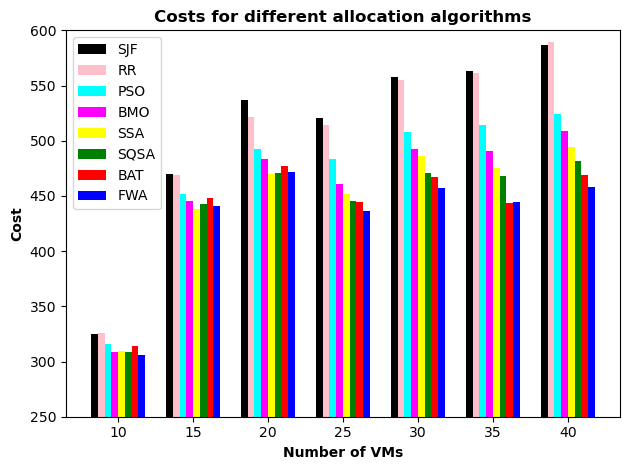

In [73]:
plt.bar(r1, cost_vm_df['SJF'], color='black', width=bar_width, label='SJF')
plt.bar(r2, cost_vm_df['RR'], color='pink', width=bar_width, label='RR')
plt.bar(r3, cost_vm_df['PSO'], color='cyan', width=bar_width, label='PSO')
plt.bar(r4, cost_vm_df['BMO'], color='magenta', width=bar_width, label='BMO')
plt.bar(r5, cost_vm_df['SSA'], color='yellow', width=bar_width, label='SSA')

plt.bar(r6, cost_vm_df['SQSA'], color='green', width=bar_width, label='SQSA')
plt.bar(r7, cost_vm_df['BAT'], color='red', width=bar_width, label='BAT')

plt.bar(r8, cost_vm_df['FWA'], color='blue', width=bar_width, label='FWA')

plt.xlabel('Number of VMs', fontweight='bold')
plt.ylabel('Cost', fontweight='bold')
plt.title('Costs for different allocation algorithms', fontweight='bold')
plt.xticks([r + bar_width*3.5 for r in range(len(cost_vm_df['No of VMs']))], cost_vm_df['No of VMs'])

plt.ylim(250, 600)

plt.legend()

plt.tight_layout()
plt.show()


In [74]:
cost_task_df=pd.read_excel("cost vs task 2.xlsx")

In [75]:
cost_task_df

,No of Tasks,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,40,221.864169,222.761101,181.307046,172.153725,186.156727,198.402897,188.848631,183.965532
1,50,270.011023,270.357121,208.241274,209.479435,220.202021,237.145815,229.112199,213.419658
2,60,360.430813,360.938926,284.503415,287.227962,283.444481,318.860432,302.487126,290.436742
3,70,410.707769,411.856553,339.624416,334.002407,352.340518,373.893731,358.706109,337.592163
4,100,573.587505,573.233991,461.384704,483.394960,468.268521,520.994189,503.206992,490.611581
5,150,773.910720,781.438072,669.669981,695.876084,675.685703,730.470104,712.962478,706.197953


In [76]:
plt.figure(figsize=(25,20))

<Figure size 2500x2000 with 0 Axes>

<Figure size 2500x2000 with 0 Axes>

In [77]:
bar_width = 0.09
r1 = range(len(cost_task_df['No of Tasks']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]
r8 = [x + bar_width for x in r7]

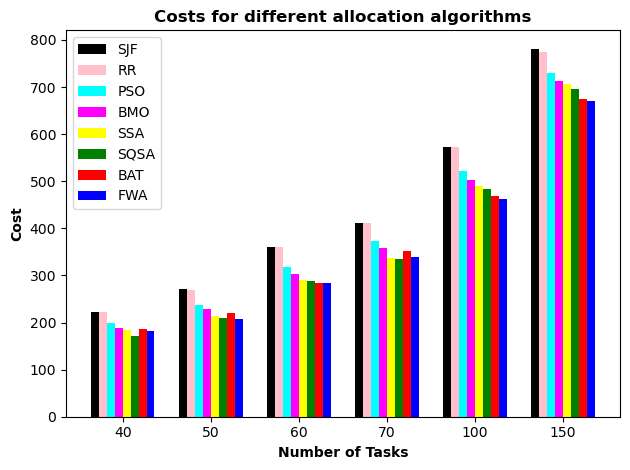

In [79]:
plt.bar(r1, cost_task_df['SJF'], color='black', width=bar_width, label='SJF')
plt.bar(r2, cost_task_df['RR'], color='pink', width=bar_width, label='RR')
plt.bar(r3, cost_task_df['PSO'], color='cyan', width=bar_width, label='PSO')
plt.bar(r4, cost_task_df['BMO'], color='magenta', width=bar_width, label='BMO')
plt.bar(r5, cost_task_df['SSA'], color='yellow', width=bar_width, label='SSA')
plt.bar(r6, cost_task_df['SQSA'], color='green', width=bar_width, label='SQSA')
plt.bar(r7, cost_task_df['BAT'], color='red', width=bar_width, label='BAT')
plt.bar(r8, cost_task_df['FWA'], color='blue', width=bar_width, label='FWA')

plt.xlabel('Number of Tasks', fontweight='bold')
plt.ylabel('Cost', fontweight='bold')
plt.title('Costs for different allocation algorithms', fontweight='bold')
plt.xticks([r + bar_width*3.5 for r in range(len(cost_task_df['No of Tasks']))], cost_task_df['No of Tasks'])


plt.legend()

plt.tight_layout()
plt.show()

In [86]:
energy_vm_df=pd.read_excel("energy vs vm 2.xlsx")

In [87]:
energy_vm_df

,No of VMs,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,10,1.690669,1.681327,1.539971,1.542770,1.592983,1.602920,1.541886,1.538309
1,15,2.713577,2.737240,2.492727,2.437267,2.564152,2.542549,2.480072,2.441914
2,20,2.865236,3.015303,2.482737,2.293156,2.492973,2.574584,2.464807,2.350688
3,25,2.881187,2.973211,2.181896,2.154178,2.304066,2.587685,2.324047,2.203588
4,30,3.431461,3.463336,2.452345,2.404746,2.589216,2.868654,2.707426,2.638588
5,35,3.450209,3.462311,2.306849,2.357581,2.314211,2.928384,2.607616,2.466589
6,40,3.725988,3.693244,2.386503,2.437955,2.534019,2.960306,2.788281,2.604782


In [82]:
plt.figure(figsize=(25,20))

<Figure size 2500x2000 with 0 Axes>

<Figure size 2500x2000 with 0 Axes>

In [84]:
bar_width = 0.09
r1 = range(len(energy_vm_df['No of VMs']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]
r8 = [x + bar_width for x in r7]

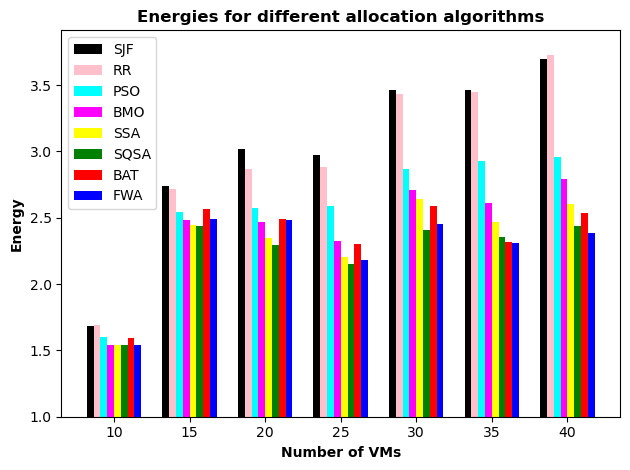

In [90]:
plt.bar(r1, energy_vm_df['SJF'], color='black', width=bar_width, label='SJF')
plt.bar(r2, energy_vm_df['RR'], color='pink', width=bar_width, label='RR')
plt.bar(r3, energy_vm_df['PSO'], color='cyan', width=bar_width, label='PSO')
plt.bar(r4, energy_vm_df['BMO'], color='magenta', width=bar_width, label='BMO')
plt.bar(r5, energy_vm_df['SSA'], color='yellow', width=bar_width, label='SSA')

plt.bar(r6, energy_vm_df['SQSA'], color='green', width=bar_width, label='SQSA')
plt.bar(r7, energy_vm_df['BAT'], color='red', width=bar_width, label='BAT')

plt.bar(r8, energy_vm_df['FWA'], color='blue', width=bar_width, label='FWA')

plt.xlabel('Number of VMs', fontweight='bold')
plt.ylabel('Energy', fontweight='bold')
plt.title('Energies for different allocation algorithms', fontweight='bold')
plt.xticks([r + bar_width*3.5 for r in range(len(energy_vm_df['No of VMs']))], energy_vm_df['No of VMs'])

plt.ylim(1)

plt.legend()

plt.tight_layout()
plt.show()

In [91]:
energy_task_df=pd.read_excel("Energy vs task 2.xlsx")

In [92]:
energy_task_df

,No of Tasks,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,40,1.628516,1.654265,1.001985,0.954076,1.050232,1.283493,1.094436,1.004018
1,50,1.793789,1.838367,1.316821,1.087307,1.395130,1.433944,1.291075,1.258292
2,60,2.372618,2.380703,1.594865,1.506329,1.543471,1.879251,1.689366,1.588725
3,70,2.502110,2.494817,1.850538,1.594127,1.956910,2.071446,1.907841,1.707665
4,100,3.356497,3.432659,2.798496,2.672749,2.873112,2.974152,2.873852,2.795056
5,150,3.528709,3.535136,3.264491,3.287681,3.396261,3.410273,3.313241,3.285107


In [93]:
plt.figure(figsize=(25,20))

<Figure size 2500x2000 with 0 Axes>

<Figure size 2500x2000 with 0 Axes>

In [94]:
bar_width = 0.09
r1 = range(len(energy_task_df['No of Tasks']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]
r8 = [x + bar_width for x in r7]

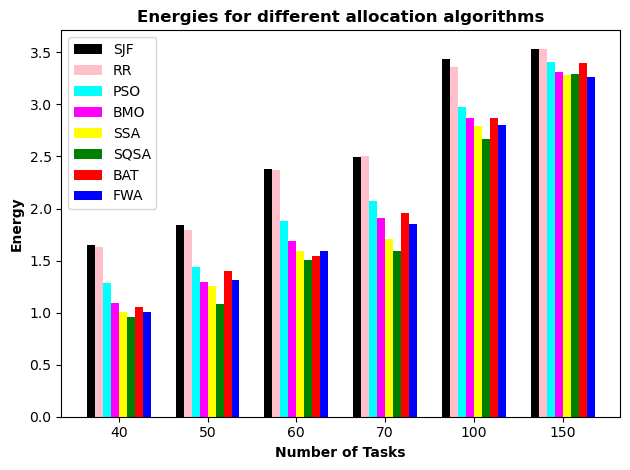

In [95]:
plt.bar(r1, energy_task_df['SJF'], color='black', width=bar_width, label='SJF')
plt.bar(r2, energy_task_df['RR'], color='pink', width=bar_width, label='RR')
plt.bar(r3, energy_task_df['PSO'], color='cyan', width=bar_width, label='PSO')
plt.bar(r4, energy_task_df['BMO'], color='magenta', width=bar_width, label='BMO')
plt.bar(r5, energy_task_df['SSA'], color='yellow', width=bar_width, label='SSA')
plt.bar(r6, energy_task_df['SQSA'], color='green', width=bar_width, label='SQSA')
plt.bar(r7, energy_task_df['BAT'], color='red', width=bar_width, label='BAT')
plt.bar(r8, energy_task_df['FWA'], color='blue', width=bar_width, label='FWA')

plt.xlabel('Number of Tasks', fontweight='bold')
plt.ylabel('Energy', fontweight='bold')
plt.title('Energies for different allocation algorithms', fontweight='bold')
plt.xticks([r + bar_width*3.5 for r in range(len(energy_task_df['No of Tasks']))], energy_task_df['No of Tasks'])


plt.legend()

plt.tight_layout()
plt.show()

# Makespan results ->

In [117]:
makespan_resultSS=pd.DataFrame(columns=["max task CPU","max task memory","RR","SJF","FWA","SQSA","BAT","PSO","BMO","SSA"])

In [118]:
rr_mean_makespan=0
sjf_mean_makespan=0
fwa_mean_makespan=0
sqsa_mean_makespan=0
bat_mean_makespan=0
pso_mean_makespan=0
bmo_mean_makespan=0
ssa_mean_makespan=0

In [119]:
num_vms=40
num_tasks=100

In [158]:
maxx=350
n=5
for _ in range(n):
    vms = [VM(i, random.randint(1000, 3000), random.randint(1000, 2000)) for i in range(num_vms)]
    tasks = [Task(i, random.randint(50, maxx), random.randint(50, maxx), random.randint(50, 500)) for i in range(num_tasks)]
    
    # RR
    rr_makespan= rr_optimize(vms, tasks)[0]
    rr_mean_makespan+=rr_makespan
    
    # SJF
    sjf_makespan= sjf_optimize(vms, tasks)[0]
    sjf_mean_makespan+=sjf_makespan
    
    #FWA
    fwa_makespan= fwa_optimize(vms, tasks)[0]
    fwa_mean_makespan+=fwa_makespan
    
    #SQSA
    sqsa_makespan= sqsa_optimize(vms, tasks)[0]
    sqsa_mean_makespan+=sqsa_makespan

    #BAT
    bat_makespan= bat_optimize(vms, tasks)[0]
    bat_mean_makespan+=bat_makespan
    
    #PSO
    pso_makespan= pso_optimize(vms, tasks)[0]
    pso_mean_makespan+=pso_makespan

    #BMO
    bmo_makespan= bmo_optimize(vms, tasks)[0]
    bmo_mean_makespan+=bmo_makespan
    
    #SSA
    ssa_makespan= ssa_optimize(vms, tasks)[0]
    ssa_mean_makespan+=ssa_makespan

# RR
rr_mean_makespan/=n
print("--RR--",rr_mean_makespan)

#SJF
sjf_mean_makespan/=n
print("--SJF--",sjf_mean_makespan)

#FWA
fwa_mean_makespan/=n
print("--FWA--",fwa_mean_makespan)
    
#SQSA
sqsa_mean_makespan/=n
print("--SQSA--",sqsa_mean_makespan)

#BAT
bat_mean_makespan/=n
print("--BAT--",bat_mean_makespan)
    
#PSO
pso_mean_makespan/=n
print("--PSO--",pso_mean_makespan)

#BMO
bmo_mean_makespan/=n
print("--BMO--",bmo_mean_makespan)

#SSA
ssa_mean_makespan/=n
print("--SSA--",ssa_mean_makespan)

--RR-- 381.42480631707747
--SJF-- 389.45766599993476
--FWA-- 290.7795686506453
--SQSA-- 271.06694249518694
--BAT-- 335.3133090522925
--PSO-- 337.0593315453808
--BMO-- 306.3617957247453
--SSA-- 307.9251095174601


In [159]:
makespan_resultSS.loc[5]=[maxx,maxx,rr_mean_makespan,sjf_mean_makespan,fwa_mean_makespan,sqsa_mean_makespan,bat_mean_makespan,pso_mean_makespan,bmo_mean_makespan,ssa_mean_makespan]

In [160]:
makespan_resultSS

,max task CPU,max task memory,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,100.0,100.0,85.490122,84.712605,64.153695,60.737885,70.179464,70.136827,67.990053,67.547998
1,150.0,150.0,152.441602,146.423700,105.128693,110.324668,119.189744,125.975898,120.808843,109.755718
2,200.0,200.0,201.181418,206.954041,156.689402,146.590138,161.141215,174.944137,169.800495,161.308764
3,250.0,250.0,249.285277,253.365512,176.883314,171.879438,184.671580,211.003155,189.368258,183.500985
4,300.0,300.0,327.037005,325.801085,228.848153,220.253475,264.054259,276.591812,252.501458,250.740588
5,350.0,350.0,381.424806,389.457666,290.779569,271.066942,335.313309,337.059332,306.361796,307.925110


In [163]:
makespan_computing_df=pd.read_excel("makespan vs computing.xlsx")

In [164]:
makespan_computing_df

,max task CPU,max task memory,RR,SJF,FWA,SQSA,BAT,PSO,BMO,SSA
0,100,100,85.490122,84.712605,64.153695,60.737885,70.179464,70.136827,67.990053,67.547998
1,150,150,152.441602,146.423700,105.128693,110.324668,119.189744,125.975898,120.808843,109.755718
2,200,200,201.181418,206.954041,156.689402,146.590138,161.141215,174.944137,169.800495,161.308764
3,250,250,249.285277,253.365512,176.883314,171.879438,184.671580,211.003155,189.368258,183.500985
4,300,300,327.037005,325.801085,228.848153,220.253475,264.054259,276.591812,252.501458,250.740588
5,350,350,381.424806,389.457666,290.779569,271.066942,335.313309,337.059332,306.361796,307.925110


In [165]:
plt.figure(figsize=(25,20))

<Figure size 2500x2000 with 0 Axes>

<Figure size 2500x2000 with 0 Axes>

In [166]:
bar_width = 0.09
r1 = range(len(makespan_computing_df['max task CPU']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]
r8 = [x + bar_width for x in r7]

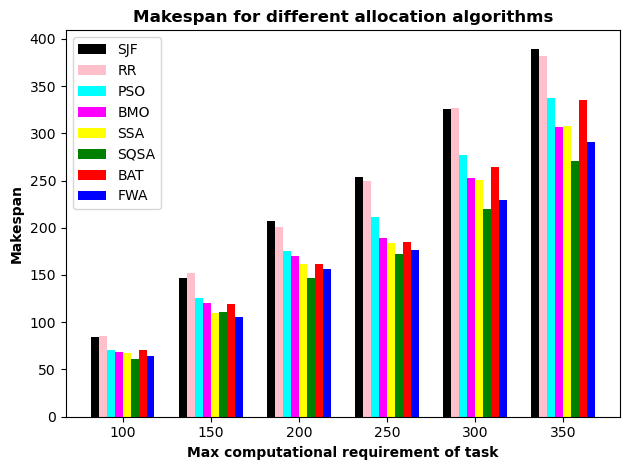

In [168]:
plt.bar(r1, makespan_computing_df['SJF'], color='black', width=bar_width, label='SJF')
plt.bar(r2, makespan_computing_df['RR'], color='pink', width=bar_width, label='RR')
plt.bar(r3, makespan_computing_df['PSO'], color='cyan', width=bar_width, label='PSO')
plt.bar(r4, makespan_computing_df['BMO'], color='magenta', width=bar_width, label='BMO')
plt.bar(r5, makespan_computing_df['SSA'], color='yellow', width=bar_width, label='SSA')
plt.bar(r6, makespan_computing_df['SQSA'], color='green', width=bar_width, label='SQSA')
plt.bar(r7, makespan_computing_df['BAT'], color='red', width=bar_width, label='BAT')
plt.bar(r8, makespan_computing_df['FWA'], color='blue', width=bar_width, label='FWA')

plt.xlabel('Max computational requirement of task', fontweight='bold')
plt.ylabel('Makespan', fontweight='bold')
plt.title('Makespan for different allocation algorithms', fontweight='bold')
plt.xticks([r + bar_width*3.5 for r in range(len(makespan_computing_df['max task CPU']))], makespan_computing_df['max task CPU'])


plt.legend()

plt.tight_layout()
plt.show()

### Best fitness graphs ->

In [205]:
bmo_best_fitness=[]
ssa_best_fitness=[]

In [212]:
#FWA
def fwa_optimize_graphed(vms,tasks):
    fwa_best_fitness=[]
    def generate_sparks(firework, n, amplitude, num_vms):
        return [
            [max(0, min(num_vms - 1, x + int(random.uniform(-amplitude, amplitude))))
             for x in firework]
            for _ in range(n)
        ]
    def fireworks_algorithm(vms, tasks, n_fireworks=5, n_sparks=30, n_iterations=40):
        num_vms = len(vms)
        num_tasks = len(tasks)

        # Initialize fireworks
        fireworks = [random.choices(range(num_vms), k=num_tasks) for _ in range(n_fireworks)]
        best_solution = None
        best_fitness = float('inf')

        for _ in range(n_iterations):
            all_solutions = fireworks.copy()

            # Generate sparks
            for firework in fireworks:
                fitness = check_fitness(firework)[0]
                if fitness < best_fitness:
                    best_fitness = fitness
                    best_solution = firework

                # Calculate amplitude, ensuring it's within a reasonable range
                amplitude = max(1, int(50 * best_fitness / fitness))

                all_solutions.extend(generate_sparks(firework, n_sparks, amplitude, num_vms))

            # Evaluate and select best solutions
            all_solutions.sort(key=lambda x: check_fitness(x)[0])
            fireworks = all_solutions[:n_fireworks]
            
            ##BEST FITNESS APPENDED
            fwa_best_fitness.append(best_fitness)

        return best_solution, best_fitness

    best_solution, best_fitness = fireworks_algorithm(vms, tasks)
    return fwa_best_fitness

In [213]:
#SQSA
def sqsa_optimize_graphed(vms, tasks, n_squirrels=30, n_iterations=40):
    sqsa_best_fitness=[]
    squirrels = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_squirrels)]
    fitness = [check_fitness(s)[0] for s in squirrels]

    best_idx = fitness.index(min(fitness))
    
    for _ in range(n_iterations):
        for i in range(n_squirrels):
            if i != best_idx:
                for j in range(len(tasks)):
                    if random.random() < 0.5:
                        squirrels[i][j] = squirrels[best_idx][j]
                    else:
                        squirrels[i][j] = random.randint(0, len(vms)-1)
        
        fitness = [check_fitness(s)[0] for s in squirrels]
        new_best_idx = fitness.index(min(fitness))
        
        ## BEST FITNESS APPENDED
        sqsa_best_fitness.append(min(fitness))
        
        if fitness[new_best_idx] < fitness[best_idx]:
            best_idx = new_best_idx

    return sqsa_best_fitness

In [214]:
#BAT
def bat_optimize_graphed(vms, tasks, n_bats=30, n_iterations=40):
    bat_best_fitness=[]
    
    bats = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_bats)]
    velocities = [[0] * len(tasks) for _ in range(n_bats)]
    fitness = [check_fitness(b)[0] for b in bats]
    best_bat = bats[fitness.index(min(fitness))]
    best_fitness = min(fitness)
    
    for _ in range(n_iterations):
        for i in range(n_bats):
            # Generate new solution
            freq = random.random()
            new_bat = []
            for j in range(len(tasks)):
                velocities[i][j] += (bats[i][j] - best_bat[j]) * freq
                new_position = bats[i][j] + velocities[i][j]
                new_bat.append(max(0, min(len(vms)-1, int(new_position))))
            
            # Local search
            if random.random() > 0.5:
                new_bat = [max(0, min(len(vms)-1, best_bat[j] + int(random.gauss(0, 1))))
                           for j in range(len(tasks))]
            
            # Evaluate new solution
            new_fitness = check_fitness(new_bat)[0]
            
            # Update if better
            if new_fitness < fitness[i]:
                bats[i] = new_bat
                fitness[i] = new_fitness
                if new_fitness < best_fitness:
                    best_fitness = new_fitness
                    best_bat = new_bat
        
        bat_best_fitness.append(best_fitness)
    
    return bat_best_fitness

In [215]:
# PSO
def pso_optimize_graphed(vms, tasks, n_particles=30, n_iterations=40):
    pso_best_fitness=[]
    
    particles = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_particles)]
    velocities = [[0] * len(tasks) for _ in range(n_particles)]
    personal_best = particles.copy()
    fitness = [check_fitness(p)[0] for p in particles]
    global_best = particles[fitness.index(min(fitness))]
    best_fitness = min(fitness)
    
    for _ in range(n_iterations):
        for i in range(n_particles):
            # Update velocity and position
            new_particle = []
            for j in range(len(tasks)):
                r1, r2 = random.random(), random.random()
                velocities[i][j] = (0.5 * velocities[i][j] + 
                                    1 * r1 * (personal_best[i][j] - particles[i][j]) +
                                    2 * r2 * (global_best[j] - particles[i][j]))
                new_position = particles[i][j] + velocities[i][j]
                new_particle.append(max(0, min(len(vms)-1, int(new_position))))
            
            # Evaluate new position
            current_fitness = check_fitness(new_particle)[0]
            
            # Update personal best
            if current_fitness < fitness[i]:
                personal_best[i] = new_particle
                fitness[i] = current_fitness
                
                # Update global best
                if current_fitness < best_fitness:
                    best_fitness = current_fitness
                    global_best = new_particle
            
            # Update particle position
            particles[i] = new_particle
        
        pso_best_fitness.append(best_fitness)

    return pso_best_fitness

In [216]:
# BMO
def bmo_optimize_graphed(vms, tasks, n_barnacles=30, n_iterations=40):
    bmo_best_fitness=[]
    barnacles = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_barnacles)]
    fitness = [check_fitness(b)[0] for b in barnacles]
    best_barnacle = barnacles[fitness.index(min(fitness))]
    best_fitness = min(fitness)
    
    for _ in range(n_iterations):
        for i in range(n_barnacles):
            if random.random() < 0.5:  # Pseudo-fertilization
                partner = random.choice(barnacles)
                barnacles[i] = [b if random.random() < 0.5 else p 
                                for b, p in zip(barnacles[i], partner)]
            else:  # Larval development
                barnacles[i] = [max(0, min(len(vms)-1, x + int(random.gauss(0, 1))))
                                for x in barnacles[i]]
        
        fitness = [check_fitness(b)[0] for b in barnacles]
        new_best_fitness = min(fitness)
        if new_best_fitness < best_fitness:
            best_fitness = new_best_fitness
            best_barnacle = barnacles[fitness.index(best_fitness)]
        
        bmo_best_fitness.append(best_fitness)

    return bmo_best_fitness

In [217]:
#SSA
def ssa_optimize_graphed (vms, tasks, n_sparrows=30, n_iterations=40):
    ssa_best_fitness=[]
    sparrows = [random.choices(range(len(vms)), k=len(tasks)) for _ in range(n_sparrows)]
    fitness = [check_fitness(s)[0] for s in sparrows]
    best_sparrow = sparrows[fitness.index(min(fitness))]
    
    for _ in range(n_iterations):
        for i in range(n_sparrows):
            if i < n_sparrows // 5:  # Discoverer
                sparrows[i] = [max(0, min(len(vms)-1, x + int(random.gauss(0, 1))))
                               for x in sparrows[i]]
            elif i < n_sparrows // 2:  # Joiner
                sparrows[i] = [best_sparrow[j] if random.random() < 0.5 else sparrows[i][j]
                               for j in range(len(tasks))]
            else:  # Scrounger
                sparrows[i] = [random.randint(0, len(vms)-1) if random.random() < 0.1 else sparrows[i][j]
                               for j in range(len(tasks))]
        
        fitness = [check_fitness(s)[0] for s in sparrows]
        new_best = sparrows[fitness.index(min(fitness))]
        if check_fitness(new_best)[0] < check_fitness(best_sparrow)[0]:
            best_sparrow = new_best
        
        ### BEST FITNESS APPENDED
        ssa_best_fitness.append(min(fitness))
        
    return ssa_best_fitness

In [243]:
fwa_fitness_values=fwa_optimize_graphed(vms,tasks)
fwa_fitness_values

[0.3712381940753709,
 0.3254788998025994,
 0.31756081409772285,
 0.31756081409772285,
 0.31756081409772285,
 0.31756081409772285,
 0.31756081409772285,
 0.31756081409772285,
 0.31756081409772285,
 0.31756081409772285,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856,
 0.31289668704014856]

In [244]:
sqsa_fitness_values=sqsa_optimize_graphed(vms,tasks)
sqsa_fitness_values

[0.32366911243889107,
 0.32366911243889107,
 0.32366911243889107,
 0.32366911243889107,
 0.32366911243889107,
 0.32366911243889107,
 0.32318926905758777,
 0.32318926905758777,
 0.32318926905758777,
 0.32318926905758777,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3219346288148542,
 0.3188655194940737,
 0.3188655194940737,
 0.3188655194940737,
 0.3188655194940737,
 0.3188655194940737,
 0.3188655194940737,
 0.3188655194940737,
 0.3188655194940737]

In [246]:
bat_fitness_values=bat_optimize_graphed(vms,tasks)
bat_fitness_values

[0.34237306989009086,
 0.34237306989009086,
 0.34237306989009086,
 0.33355408915207607,
 0.33355408915207607,
 0.33355408915207607,
 0.33355408915207607,
 0.33355408915207607,
 0.33199525838970007,
 0.3296359286503332,
 0.3296359286503332,
 0.3296359286503332,
 0.32318644649164546,
 0.32318644649164546,
 0.32318644649164546,
 0.32318644649164546,
 0.32318644649164546,
 0.32318644649164546,
 0.32318644649164546,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317,
 0.3148221789556317]

In [247]:
pso_fitness_values=pso_optimize_graphed(vms,tasks)
pso_fitness_values

[0.35636433672914525,
 0.35221238234540625,
 0.34188219747745463,
 0.34188219747745463,
 0.34188219747745463,
 0.3415887762841181,
 0.34103687406352357,
 0.34103687406352357,
 0.34096504788907256,
 0.3340771327567626,
 0.3340771327567626,
 0.3314016782084503,
 0.3314016782084503,
 0.3314016782084503,
 0.3286151086055321,
 0.3251510743667613,
 0.3251510743667613,
 0.3251510743667613,
 0.3251510743667613,
 0.3251510743667613,
 0.3251510743667613,
 0.3251510743667613,
 0.3251510743667613,
 0.3223605406091024,
 0.3223605406091024,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.3219260276280477,
 0.31831168351833244,
 0.31831168351833244,
 0.31831168351833244]

In [248]:
bmo_fitness_values=bmo_optimize_graphed(vms,tasks)
bmo_fitness_values

[0.347592007313761,
 0.34168018768395325,
 0.33794945776297936,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33764368227430186,
 0.33722119959899477,
 0.33722119959899477,
 0.33544072318142043,
 0.33544072318142043,
 0.33544072318142043,
 0.33544072318142043,
 0.33544072318142043,
 0.3283824988376232,
 0.3283824988376232,
 0.3283824988376232,
 0.3283824988376232,
 0.3283824988376232,
 0.3283824988376232,
 0.3283824988376232,
 0.3283824988376232,
 0.3283824988376232,
 0.3283824988376232,
 0.3283824988376232]

In [255]:
ssa_fitness_values=ssa_optimize_graphed(vms,tasks)
ssa_fitness_values

[0.3697754534484048,
 0.3662737267104266,
 0.3618172843893672,
 0.3549287495255651,
 0.34478153067961015,
 0.3392776807907887,
 0.3392776807907887,
 0.33392655119112086,
 0.33392655119112086,
 0.33214591202361066,
 0.33199641975655253,
 0.3319001604210827,
 0.3300943873949576,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995,
 0.3299448951278995]

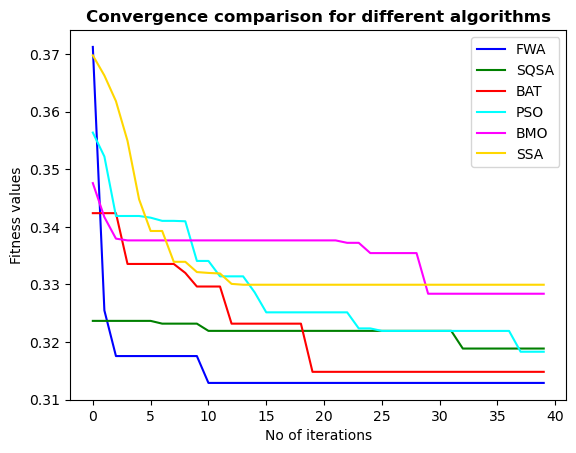

In [305]:
plt.plot(fwa_fitness_values,label="FWA",color="blue")
plt.plot(sqsa_fitness_values,label="SQSA",color="green")
plt.plot(bat_fitness_values,label="BAT",color="red")
plt.plot(pso_fitness_values,label="PSO",color="cyan")
plt.plot(bmo_fitness_values,label="BMO",color="magenta")
plt.plot(ssa_fitness_values,label="SSA",color="gold")
plt.xlabel("No of iterations")
plt.ylabel("Fitness values")
plt.title('Convergence comparison for different algorithms', fontweight='bold')
plt.legend()

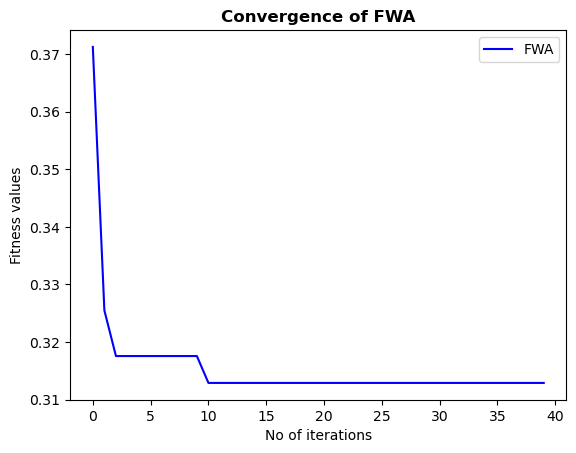

In [295]:
plt.plot(fwa_fitness_values,label="FWA",color="blue")
plt.xlabel("No of iterations")
plt.ylabel("Fitness values")
plt.title('Convergence of FWA', fontweight='bold')
plt.legend()

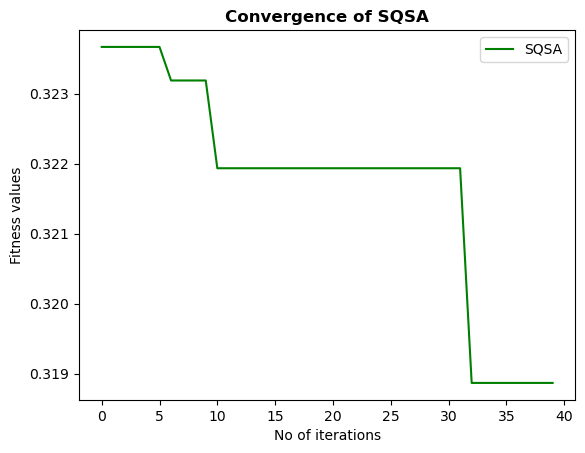

In [297]:
plt.plot(sqsa_fitness_values,label="SQSA",color="green")
plt.xlabel("No of iterations")
plt.ylabel("Fitness values")
plt.title('Convergence of SQSA', fontweight='bold')
plt.legend()

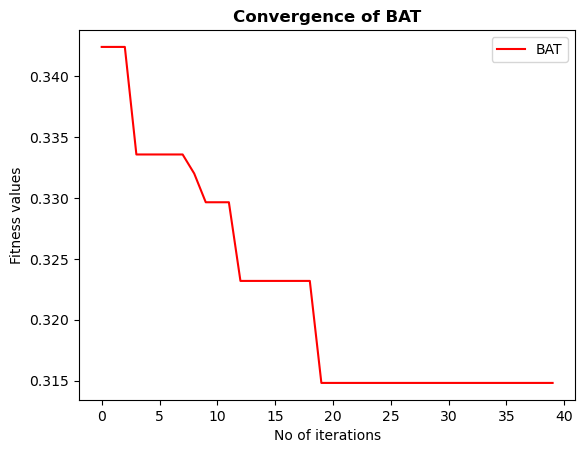

In [299]:
plt.plot(bat_fitness_values,label="BAT",color="red")
plt.xlabel("No of iterations")
plt.ylabel("Fitness values")
plt.title('Convergence of BAT', fontweight='bold')
plt.legend()

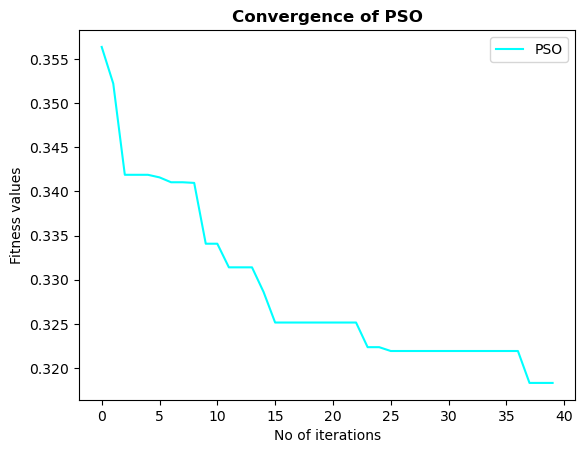

In [300]:
plt.plot(pso_fitness_values,label="PSO",color="cyan")
plt.xlabel("No of iterations")
plt.ylabel("Fitness values")
plt.title('Convergence of PSO', fontweight='bold')
plt.legend()

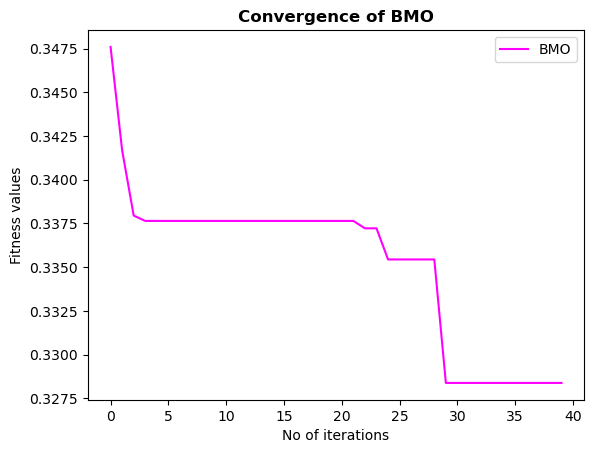

In [301]:
plt.plot(bmo_fitness_values,label="BMO",color="magenta")
plt.xlabel("No of iterations")
plt.ylabel("Fitness values")
plt.title('Convergence of BMO', fontweight='bold')
plt.legend()

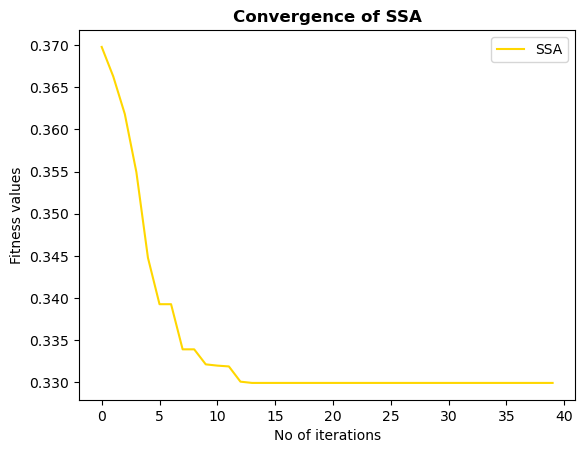

In [306]:
plt.plot(ssa_fitness_values,label="SSA",color="gold")
plt.xlabel("No of iterations")
plt.ylabel("Fitness values")
plt.title('Convergence of SSA', fontweight='bold')
plt.legend()